# Metadata

```yaml
Course:    DS 5001
Module:    M05 Lab
Topic:     Variant TFIDFs and Document Significance
Author:    R.C. Alvarado
Date:      12 February 2023
```

# Exposition

* Three kinds of signficance:
  * __Local__: `TF-IDF` (significance of a term in a document; related to $p(w|d, C)$ ).
  * __Global__: Aggregate `TF-IDF` by term (significane of a term in the corpus; related to $p( w|C ) $ ).
  * __Document__: Aggreate `TF-IDF` by document (significance of document in the corpus; related to $p(d|W_d,C) $ ).
* `TF-IDF` is essentially local frequency balanced by global frequency.
* `DF-IDF` = `TF-IDF` Σ for boolean counts.
* `DF-IDF` is global boolean term entropy.
* Boolean counts are bad for computing local significance, but good for global.
* Max normalization is good for local significance.
* Context matters for document signficance, i.e. chapter significance should be computing with the context of the novel, not the corpus.

# Set Up

In [2]:
data_in = '../data/output'
data_out = '../data/output'
data_prefix = 'austen-melville'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go # For more control on graphs
import re

In [4]:
sns.set()

# Get Data

In [5]:
LIB = pd.read_csv(f"{data_in}/{data_prefix}-LIB.csv").set_index('book_id')

In [6]:
# LIB['title'] = LIB.title.str.split(r',? by').apply(lambda x: x[0])
# LIB['author'] = LIB.apply(lambda x: re.split(r',? by', x.title)[-1], 1)
# for idx in [15859, 13720, 53861, 13721]:
#     LIB.loc[idx, 'author'] = 'Herman Melville'
# LIB = LIB[['title','author']]

In [7]:
LIB

source_file_path            author  \
book_id                                                                        
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
946      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1212     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1342     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1900     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
2701     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
4045     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
8118     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
10712    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13720    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13721    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
15422    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
15859    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
21816    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
34970    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   

                                                     title  \
book_id                                                      
105                                             PERSUASION   
121                                       NORTHANGER ABBEY   
141                                         MANSFIELD PARK   
158                                                   EMMA   
161                                  SENSE AND SENSIBILITY   
946                                             LADY SUSAN   
1212                               LOVE AND FREINDSHIP SIC   
1342                                   PRIDE AND PREJUDICE   
1900                     TYPEE A ROMANCE OF THE SOUTH SEAS   
2701                                MOBY DICK OR THE WHALE   
4045                     OMOO ADVENTURES IN THE SOUTH SEAS   
8118     REDBURN HIS FIRST VOYAGE BEING THE SAILOR BOY ...   
10712            WHITE JACKET OR THE WORLD ON A MAN OF WAR   
13720                     MARDI AND A VOYAGE THITHER VOL I   
13721                    MARDI AND A VOYAGE THITHER VOL II   
15422               ISRAEL POTTER HIS FIFTY YEARS OF EXILE   
15859                                     THE PIAZZA TALES   
21816                    THE CONFIDENCE MAN HIS MASQUERADE   
34970                            PIERRE OR THE AMBIGUITIES   

                              chap_regex  book_len  n_chaps  
book_id                                                      
105                      ^Chapter\s+\d+$     83624       24  
121                      ^CHAPTER\s+\d+$     77601       31  
141                ^CHAPTER\s+[IVXLCM]+$    160378       48  
158          ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926       55  
161                      ^CHAPTER\s+\d+$    119873       50  
946                    ^\s*[IVXLCM]+\s*$     23116       41  
1212                ^\s*LETTER .* to .*$     33265       24  
1342                     ^Chapter\s+\d+$    122126       61  
1900                           ^CHAPTER     108021       34  
2701     ^(?:ETYMOLOGY|EXTRACTS|CHAPTER)    215504      138  
4045       ^\s*CHAPTER\s+[IVXLCM]+\.\s*$    102352       82  
8118                 ^\s*[IVXLCM]+\. .*$    119243       78  
10712         ^CHAPTER\s+[IVXLCM]+\.\s*$    143310       92  
13720        ^\s*CHAPTER\s+[IVXLCM]+\s*$     96878      104  
13721        ^\s*CHAPTER\s+[IVXLCM]+\s*$    102092       91  
1542

In [8]:
TOKEN = pd.read_csv(f'{data_in}/{data_prefix}-TOKEN.csv')
OHCO = TOKEN.columns.to_list()[:5] 
TOKEN = TOKEN.set_index(OHCO)

In [9]:
VOCAB = pd.read_csv(f'{data_in}/{data_prefix}-VOCAB.csv').set_index('term_str')
# VOCAB = VOCAB.drop('term_id', 1) # We will forego using numeric term_ids and just use the term_str
VOCAB['pos_max'] = TOKEN.groupby(['term_str','pos']).pos.count().unstack().idxmax(1)
VOCAB['pos_group'] = VOCAB.max_pos.str[:2]
VOCAB['term_code'] = VOCAB.apply(lambda x: str(x.name) + '/' + x.max_pos, 1)
VOCAB['term_len'] = VOCAB.index.str.len()

In [34]:
POS = VOCAB.groupby('pos_max').n.sum().to_frame('n_sum')
POS['p_mean'] = VOCAB.groupby('pos_max').p.mean();

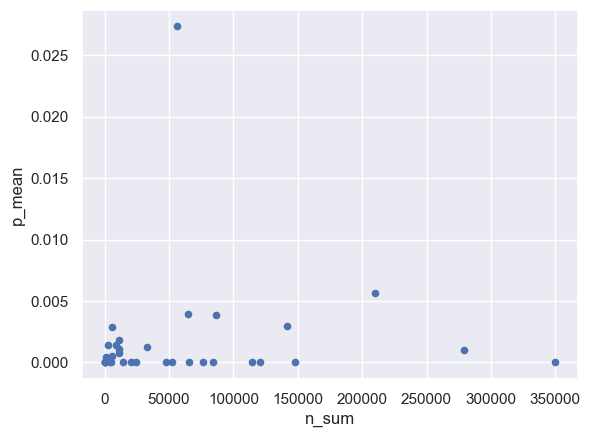

In [35]:
POS.plot.scatter('n_sum', 'p_mean');

# Recreate BOW

In [9]:
# BAG = OHCO[:1] # Book
BAG = OHCO[:2] # Chapter
# BAG = OHCO[:3] # Paragraph

In [10]:
BOW = TOKEN.groupby(BAG + ['term_str']).term_str.count().to_frame('n')

In [11]:
BOW

n
book_id chap_num term_str   
105     1        1         2
                 15        1
                 16        1
                 1760      1
                 1784      1
...                       ..
53861   15       yet       2
                 you       1
                 young     3
                 your      1
                 zebra     1

[731536 rows x 1 columns]

## Extract the DOCS table

This is a table of bag-level observations. We'll use this later when exploring document level significance.

In [12]:
DOCS = BOW.groupby(BAG).n.sum().to_frame('n')

In [13]:
DOCS

n
book_id chap_num      
105     1         2625
        2         1974
        3         2837
        4         1805
        5         3322
...                ...
53861   8         2286
        11        3387
        13        2180
        14        2790
        15        2513

[1122 rows x 1 columns]

# Local Significance (TFIDF)

## Traditional

In [14]:
TF = BOW.n.unstack(fill_value=0) # Document-Term Count Matrix
DF = TF.astype('bool').sum() 
N = len(DOCS)
IDF = np.log2(N/DF)      
TFIDF = TF * IDF
TFIDF_agg = TFIDF.sum()

In [15]:
TFIDF_agg.sort_values(ascending=False).head(20)

term_str
she          10147.034980
her           9340.136767
mr            5368.081714
you           5117.779036
pierre        5089.597669
mrs           4599.970085
i             4338.610084
miss          3790.908454
fanny         3554.708113
emma          3383.286987
whale         3358.816595
sir           3162.338202
captain       2973.754321
me            2962.274984
elinor        2832.715249
your          2789.668389
my            2750.546355
israel        2737.141626
elizabeth     2612.442505
am            2541.677752
dtype: float64

## Variants

In [16]:
tf_variants = {
    'raw': lambda tf: tf,
    'rel': lambda tf: (tf.T / tf.T.sum()).T,
    'max': lambda tf, alpha=.4: alpha + (1 - alpha) * (tf.T / tf.T.max()).T,
    'log': lambda tf: np.log2(1 + tf),
    'bool': lambda tf: tf.astype('bool').astype('int'),
    # 'sub': lambda tf: 1 + np.log2(tf)
}

In [17]:
tfidf_variants = {k: tf_variants[k](TF) * IDF for k, v in tf_variants.items()}

# Global Significance

Global significance in this context means aggregate significance for the whole corpus.

We get the sums of each variant TF.

In [18]:
tfidf_sums = {k: v.sum().to_frame('sum_val') for k, v in tfidf_variants.items()}

In [19]:
SUMS = pd.concat([v.sort_values('sum_val', ascending=False).head(20).reset_index() 
    for v in tfidf_sums.values()], keys=tfidf_sums.keys(), axis=1)

In [20]:
SUMS.style.background_gradient('YlGnBu')

We compare sums to means.

In [21]:
tfidf_means = {k: v.mean().to_frame('mean_val') for k, v in tfidf_variants.items()}

In [22]:
MEANS = pd.concat([v.sort_values('mean_val', ascending=False).head(20).reset_index() 
        for v in tfidf_means.values()], keys=tfidf_means.keys(), axis=1)

In [23]:
MEANS.style.background_gradient('YlGnBu')

Combine and compare

In [24]:
AGGS = pd.concat([SUMS,MEANS], axis=1, ignore_index=True) # We combine the two
AGGS.columns = ['_'.join(idx) + '_x' for idx in SUMS.columns] + ['_'.join(idx) + '_y' for idx in MEANS.columns] # This flattens the multiindex
AGGS = (AGGS - AGGS.mean(numeric_only=True)) / AGGS.std(numeric_only=True) # This normalizes the quantities as Z-scores
AGGS = AGGS[[col for col in AGGS.columns if 'term_str' not in col]] # This removes the string columns
AGGS = (AGGS * 100).astype('int') # This converts the numbers so they can be compact in the heatmap

In [25]:
AGGS.T.style.background_gradient(cmap='RdYlBu', axis=None)

We can see that there is no difference between mean and sum for sorting terms by global significance. 

We can also see that boolean counting produces a different distribution than the others, which are similar to each other.

## DFIDF as DH

Let's compute the global entropy of terms in the corpus and use that as another measure of global significance.

It turns out that this measure is the same as TFIDF summing from a boolean count matrix.

In [26]:
DFIDF = (DF * IDF).to_frame('val')
DP = DF / N
DI = np.log2(1/DP)
DH = (DP * DI).to_frame('val')

In [27]:
pd.concat([
        DFIDF.sort_values('val', ascending=False).head(20).reset_index(),
        DH.sort_values('val', ascending=False).head(20).reset_index(), 
        tfidf_sums['bool'].sort_values('sum_val', ascending=False).head(20).reset_index()
    ], keys=['dfidf', 'dh', 'bool'], axis=1)\
    .style.background_gradient('YlGnBu')

# Document Significance

This is an experimental concept that focuses on the amount of significance contained in a document, such as a book chapter, based on the sum or mean of TFIDF of terms in the document.

In [28]:
for k, v in tfidf_variants.items():
    DOCS[f'doc_sig_{k}'] = v.T.mean()

In [29]:
DOCS

n  doc_sig_raw  doc_sig_rel  doc_sig_max  doc_sig_log  \
book_id chap_num                                                             
105     1         2625     0.110322     0.000042     3.238681     0.089262   
        2         1974     0.076270     0.000039     3.238634     0.060954   
        3         2837     0.110183     0.000039     3.238694     0.083427   
        4         1805     0.069555     0.000039     3.238696     0.059366   
        5         3322     0.115271     0.000035     3.238649     0.090325   
...                ...          ...          ...          ...          ...   
53861   8         2286     0.119096     0.000052     3.238822     0.096705   
        11        3387     0.147621     0.000044     3.238639     0.116656   
        13        2180     0.111371     0.000051     3.238581     0.095008   
        14        2790     0.140745     0.000050     3.238722     0.103802   
        15        2513     0.139068     0.000055     3.238761     0.106439   

                  doc_sig_bool  
book_id chap_num                
105     1             0.075568  
        2             0.051353  
        3             0.067400  
        4             0.051540  
        5             0.074276  
...                        ...  
53861   8             0.083549  
        11            0.096520  
        13            0.080901  
        14            0.083654  
        15            0.093240  

[1122 rows x 6 columns]

**>>> We computes TFIDF with the book as the context.**

For example, for _Persuasion_ (`pg105`), we would use this BOW:

In [30]:
BOW.loc[105]

n
chap_num term_str   
1        1         2
         15        1
         16        1
         1760      1
         1784      1
...               ..
24       would     3
         writing   1
         wrong     1
         yet       1
         young     3

[22745 rows x 1 columns]

In [31]:
def get_chap_sigs(bow):
    X = bow.unstack(fill_value=0).astype('bool')
    df = X.sum()
    tf = (X.T / X.T.sum()).T
    idf = np.log2(len(tf)/df)
    tfidf = tf * idf
    ds = tfidf.T.mean()
    return ds

Apply to all books.

In [32]:
DOCS['book_chap_sig'] = DOCS.groupby('book_id').apply(lambda x: get_chap_sigs(BOW.loc[x.name]))

Define function to visualize chapter significance over narrative time.

In [34]:
def plot_sig_docs2(book_id, type='scatter'):

    global DOCS
    D = DOCS.loc[book_id]
    title = LIB.loc[book_id].title
    point_size = (D.n / D.n.sum()) * 700
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=D.index, y=D.book_chap_sig, 
                             text=D.index, 
                             mode = 'lines+markers+text',
                             marker = dict(size=point_size, color='#BBB'),
                             line = dict(color='#DADADA'),
                             textfont = dict(color="black")
                            ))
                  
    fig.update_layout(
        font = dict(color="#000", size=14),
        title=title,
        xaxis_title="Chapter",
        yaxis_title="Significance",
        height=800
    )
    fig.show()

Also define function to see how length and significance are related.

In [33]:
def plot_n_sig(book_id):
    ax = DOCS.loc[book_id].plot.scatter('n', 'book_chap_sig', title=f"{LIB.loc[book_id, 'title']}");
    DOCS.loc[book_id].apply(lambda row: ax.text(row.n, row.book_chap_sig, f"  {row.name}"), axis=1)

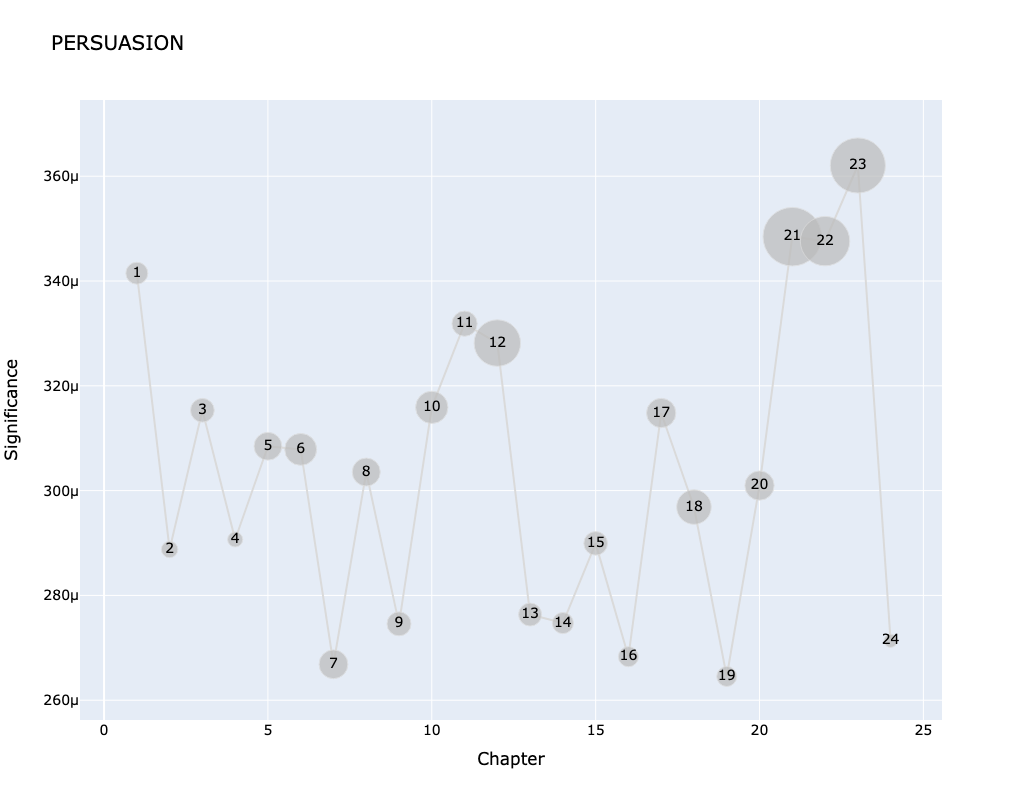

In [35]:
plot_sig_docs2(105)

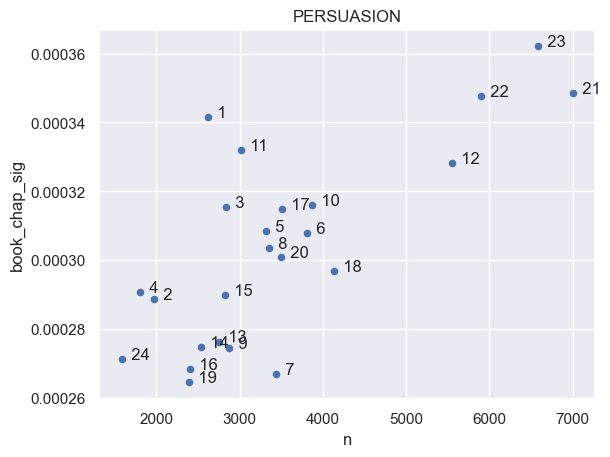

In [36]:
plot_n_sig(105)

> **Chapter 12 signals a climax in the novel's narrative.** Persuasion is a linear narrative that is organized chronologically. The original edition of this novel was published in two volumes, **the first volume ending at the close of Chapter 12**. Louisa's fall is the greatest dramatic occurrence which has happened so far. By inserting the fall here, Austen creates a cliffhanger and encourages her readers to buy the second volume of her novel. In these chapters, the reader is shown the negative effects of what can happen when one is too stubborn. Louisa would not be persuaded to keep from jumping off the wall. Her firmness of mind means serious injury for her and significant guilt for Captain Wentworth. He is encouraged to rethink his initial judgment of the benefit of a "strong character." [Sparknotes](https://www.sparknotes.com/lit/persuasion/section6/page/2/)

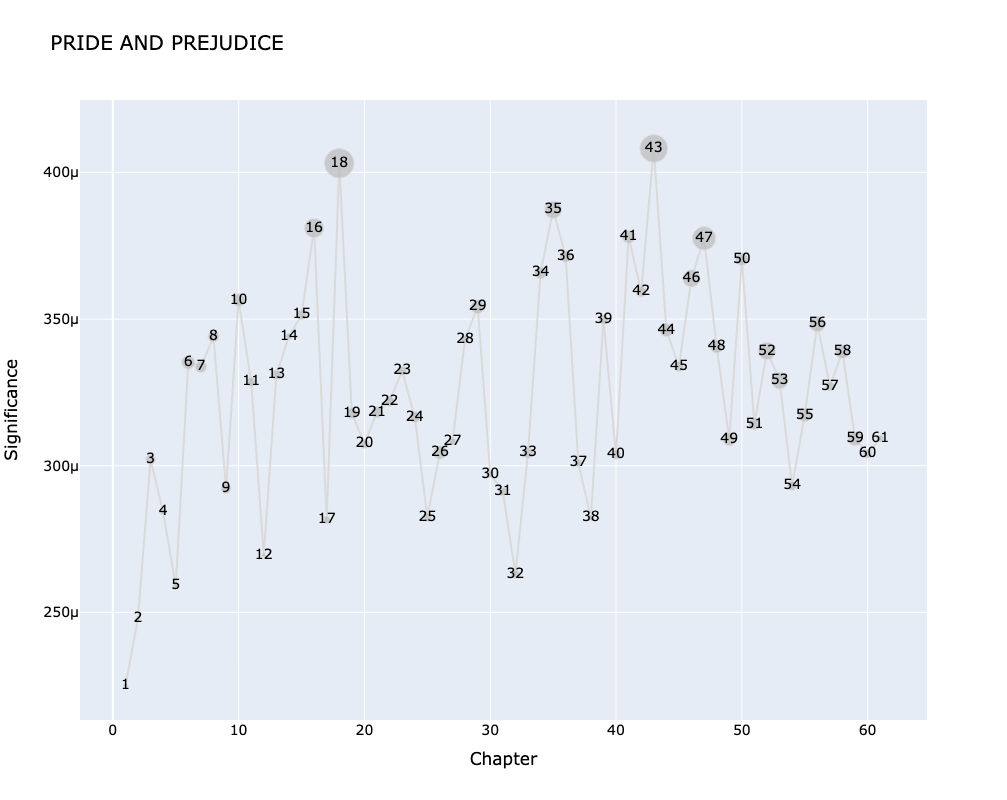

In [37]:
plot_sig_docs2(1342)

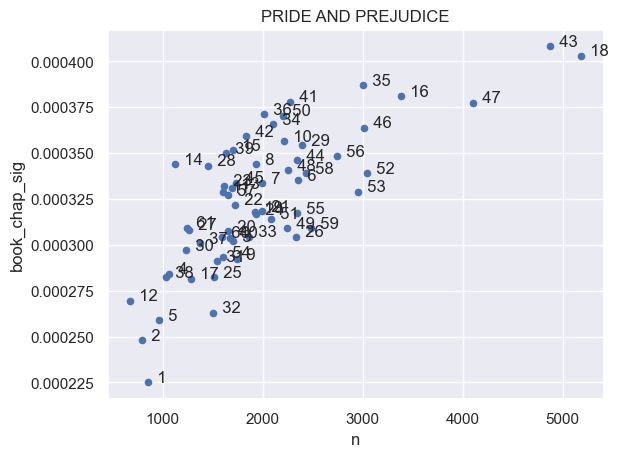

In [38]:
plot_n_sig(1342)

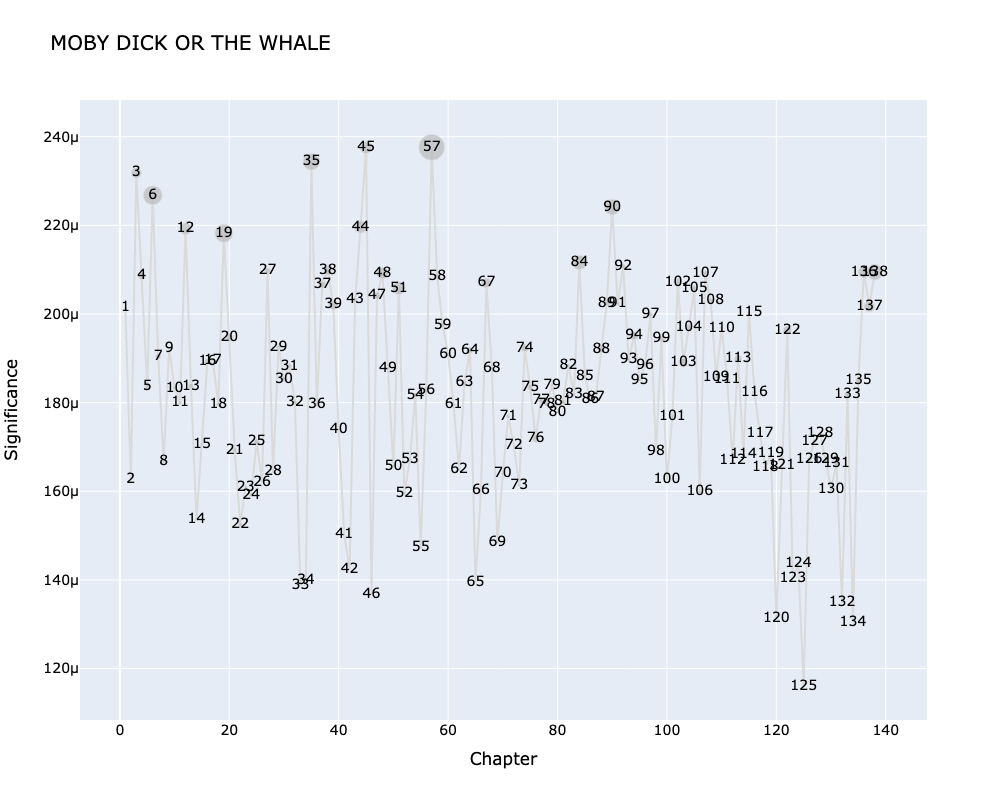

In [39]:
plot_sig_docs2(2701)

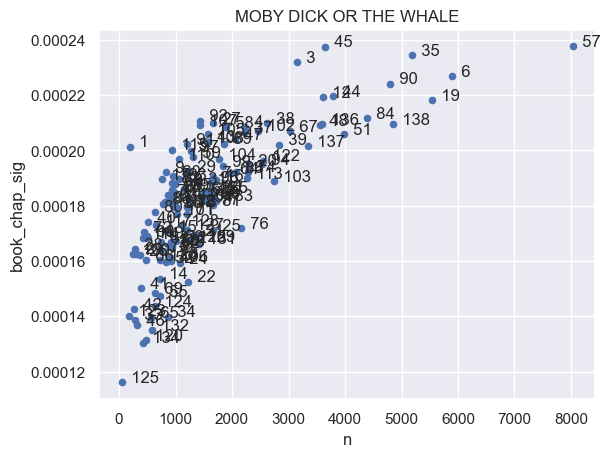

In [40]:
plot_n_sig(2701)